In [2]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

In [ ]:
import rethinking

## Why normal distributions are normal

#### Normal by addition: deviations from the mean cancel each other out

Say we have 1000 people on a random walk, step size from -1 to 1:

In [3]:
pos = torch.empty(1000, 16).uniform_(-1, 1).sum(1)

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

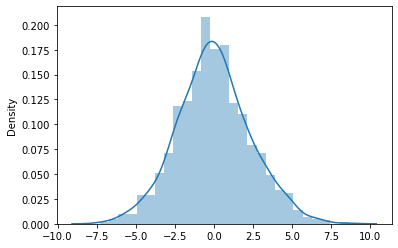

In [4]:
sns.distplot(pos)

#### Normal by multiplication: multiplying by small numbers gives roughly the same result as adding

Organism's growth rate is influenced by a dozen loci, each of which increases growth by some percentage between 0 and .1

In [5]:
growth = torch.empty(10000, 12).uniform_(1, 1.1).prod(1)

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


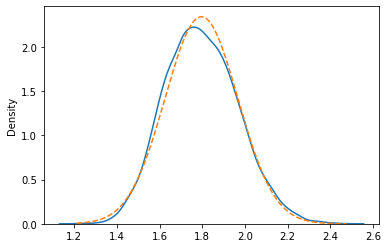

In [6]:
sns.distplot(growth, hist=False)
ax = sns.lineplot(growth, dist.Normal(growth.mean(), growth.std()).log_prob(growth).exp())
ax.lines[1].set_linestyle('--')

#### Normal by multiplication: products of larger numbers are log-normal

In [7]:
big_growth = torch.empty(10000, 12).uniform_(1, 1.5).prod(1)
small_growth = torch.empty(10000, 12).uniform_(1, 1.01).prod(1)

Multiplicative effect with small random values is approximately normal

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

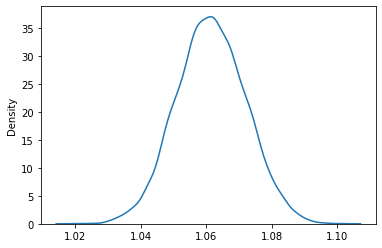

In [9]:
sns.distplot(small_growth, hist=False)


Multiplicative effect with larger random values is distinctly skewed:

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

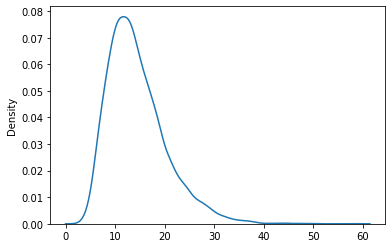

In [13]:
sns.distplot(big_growth, hist=False)


But we "rescue" normality by plotting log of product.

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

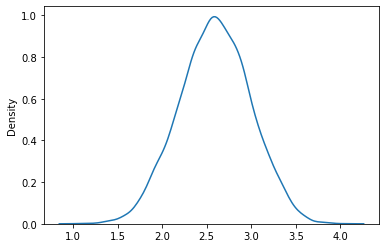

In [15]:
sns.distplot(big_growth.log(), hist=False)


### Why we'll be working so much with Gaussians:
* They arise frequently in nature, every time a process is based on adding up finite fluctuations.
* Adding up finite fluctuations erases all information about underlying process except mean and spread: Guassian is a useful model to describe these data, but cannot reliably ID microprocess creating the data.
* Gaussian is "the most natural expression of our state of ignorance": if all we can say is that a measure has finite variance, a Guassian model introduces the fewest new assumptions.

### Preview of future topics:
* Gaussian is one member of the exponential family of distributions.  Other members of this family are also frequently found in nature, and important in scientific analysis.
* Gaussian as best reflecting a state of ignorance (see above): this statement is based on information theory and maximum entropy, which will be covered in Ch.7 and 10.

## A language for describing models

1. Data = observable variables
2. Parameters = unobservable variables (rates, averages, etc)
3. We define each variable either in terms of other variables, or in terms of a probability distribution.
4. Combinoation of variables and their probability distributions defines a *joint generative model* that can both simulate hypothetical observations and analyze real ones.

## Gaussian model of height

In [17]:
d = pd.read_csv("data/Howell1.csv", sep=";")

In [18]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [19]:
d2 = d[d.age>=18]

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

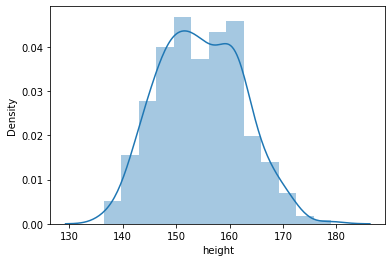

In [21]:
sns.distplot(d2.height)

Plotting priors for mu and sigma of height distribution:

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

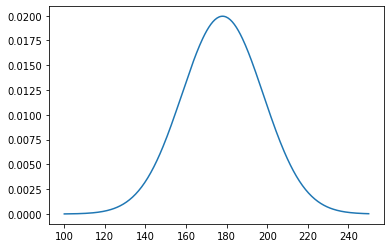

In [22]:
r = torch.linspace(start=100, end=250, steps=300)
sns.lineplot(r, dist.Normal(178, 20).log_prob(r).exp())

<AxesSubplot:>

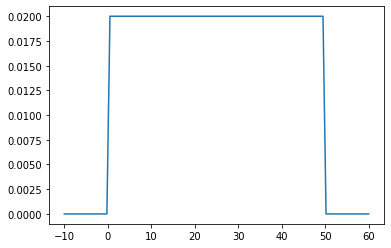

In [24]:
r = torch.linspace(start=-10, end=60, steps=101)
sns.lineplot(x=r, y=dist.Uniform(0, 50, validate_args=False).log_prob(r).exp())

Prior distribution check: draw samples from normal distribution with parameters determined by sampleing the priors for mu and beta; see if it looks sane.

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

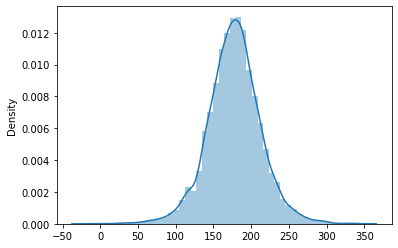

In [29]:
sample_mu = dist.Normal(178, 20).sample(torch.Size([int(1e4)]))
sample_sigma = torch.empty(int(1e4)).uniform_(0, 50)
prior_h = dist.Normal(sample_mu, sample_sigma).sample()
sns.distplot(prior_h)

#### Let's try some ugly grid approximation of our posterior probabilities for mu and sigma.

**Notes:**
* We need to grid search over every combo of mu and sigma, so in the `post` step, we repeat mu 200 times (turns it into a 200x200 matrix), and flatten that matrix so we have a single tensor <mu, mu, mu, ...>.  We repeat sigma 200 times, transpose the resulting matrix, then flatten it, which results in a single tensor with the first value of sigma repeating 200 times, then the second value of sigma repeating 200 times, etc.
* In the `post_LL` step, we initialize normal distributions using the two vectors we made in `post` as inputs.  This creates 200^2 normal distributions, one with every combination of sigma and mu.  Then for each of these resulting normal distributions, we calculate the log probability of our observed data.  This results in a tensor of length 200^2.
* In the `post_prod` step, we sum the tensor of log likelihoods of the data with the log probabilities of each corresponding mu and sigma under their respective prior distributions (`Normal(178,20)` and `Uniform(0,50)` respectively). This results in a tensor of length 200^2.
* Instead of true probabilities, we calculate relative probabilities by subtracting the maximum posterior proabability in the tensor from every value in the tensor (equivalent to dividing in probability space).  Then, we exponentiate to move from log probability space into probability space.

In [41]:
d2_height = torch.tensor(d2.height, dtype=torch.float)

In [53]:
mu_list = torch.linspace(start=150, end=160, steps=200)
sigma_list = torch.linspace(start=7, end=9, steps=200)
post = {"mu": mu_list.expand(200, 200).reshape(-1),
       "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post_LL = dist.Normal(post["mu"], post["sigma"]).log_prob(d2_height.unsqueeze(1)).sum(0)
post_prod = post_LL + dist.Normal(178, 20).log_prob(post["mu"]) + dist.Uniform(0, 50).log_prob(post['sigma'])
post_prob = (post_prod - max(post_prod)).exp()

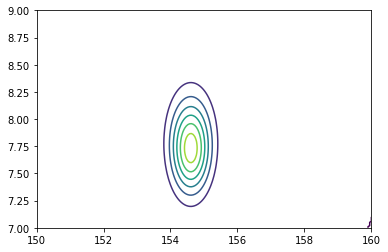

In [55]:
_, ax = sns.mpl.pyplot.subplots()
ax.contour(post["mu"].reshape(200, 200), post["sigma"].reshape(200, 200),
          post_prob.reshape(200, 200))

#### Sampling from the posterior

* First, we choose 1e4 samples from the indices of `post_prob`, with probability of choosing each index equal to the value stored there.
* Then, we use these indices to find the corresponding values of mu and sigma.

In [68]:
sample_rows = torch.multinomial(input=post_prob, num_samples = int(1e4),
                               replacement=True)
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'sample.mu'), Text(0, 0.5, 'sample.sigma')]

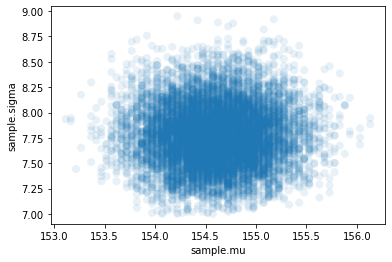

In [69]:
ax = sns.scatterplot(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none"
)
ax.set(xlabel="sample.mu", ylabel="sample.sigma")

Visualize marginal posteriors:

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

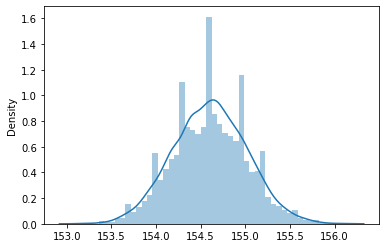

In [70]:
sns.distplot(sample_mu)

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

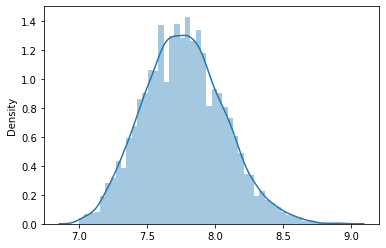

In [71]:
sns.distplot(sample_sigma)

In [72]:
stats.hpdi(sample_mu, 0.89)

tensor([153.9196, 155.2261])

In [73]:
stats.hpdi(sample_sigma, 0.89)

tensor([7.2814, 8.2161])

### Repeat analysis above with only 20 datapoints, to see that posterior of sigma is not always close to normal with limited observations

In [91]:
d3 = d2.sample(20)

In [98]:
d3_height = torch.tensor(d3.height.values, dtype=torch.float)

In [111]:
mu_list = torch.linspace(start=150, end=170, steps=200)
sigma_list = torch.linspace(start=4, end=20, steps=200)
post2 = {"mu": mu_list.expand(200, 200).reshape(-1), 
         "sigma": sigma_list.expand(200,200).t().reshape(-1)}
post2_LL = dist.Normal(post2["mu"], post2["sigma"]).log_prob(d3_height.unsqueeze(1)).sum(0)
post2_prod = post2_LL + dist.Normal(178, 20).log_prob(post2["mu"]) + dist.Uniform(0, 50).log_prob(post2["sigma"])
post2_prob = (post2_prod - max(post2_prod)).exp()

In [116]:
sample_rows_2 = torch.multinomial(input=post2_prob, num_samples=int(1e4), replacement=True)
sample_mu_2 = post2["mu"][sample_rows_2]
sample_sigma_2 = post2["sigma"][sample_rows_2]

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'mu'), Text(0, 0.5, 'sigma')]

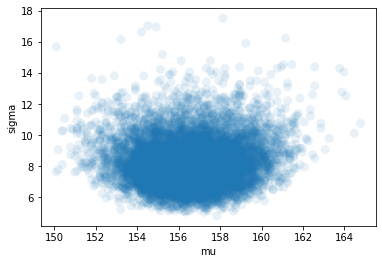

In [119]:
ax = sns.scatterplot(sample_mu_2, sample_sigma_2, s=80, alpha=0.1, edgecolor="none")
ax.set(xlabel="mu", ylabel="sigma")

Whoah, that's a long right tail in the sigma marginal posterior density plot!

/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/rachel.hovde/Library/Caches/pypoetry/virtualenvs/statistical-rethinking-DTQR2M6E-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


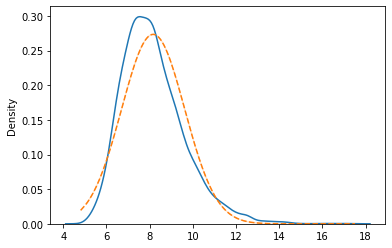

In [121]:
sns.distplot(sample_sigma_2, hist=False)
ax = sns.lineplot(sample_sigma_2, dist.Normal(sample_sigma_2.mean(), sample_sigma_2.std()).log_prob(sample_sigma_2).exp())
ax.lines[1].set_linestyle('--')

### Finding posterior distributions with quadratic approximation

Goal of quap: get a sense of the posterior distribution's shape.
* The peak of the posterior distribution lies at the Maximum a posteriori estimate (MAP), and the posterior distribution will generally be close to Gaussian in the region of this point.
* Quadratic approximation has two steps: Find the MAP using an optimization algorithm, then fit a quadratic approximation around the MAP to estimate the full posterior distribution.

In [123]:
d= pd.read_csv("data/Howell1.csv", sep=";")

In [125]:
d2 = d[d.age >=18]

In [149]:
def flist(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [141]:
height = torch.tensor(d2.height, dtype=torch.float)

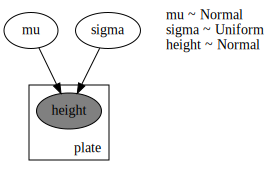

In [134]:
pyro.render_model(flist, model_args = (height,),render_params=True, render_distributions=True)

Aaargh!

In [150]:
m4_1 = rethinking.MAP(flist).run(height)

_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).

In [152]:
start = {"mu": height.mean(), "sigma": height.std()}

Works when it's given stronger prior.

In [154]:
def model(height):
    mu = pyro.sample("mu", dist.Normal(178, 0.1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = rethinking.MAP(model).run(d2_height)
rethinking.precis(m4_2)

,Mean,StdDev,|0.89,0.89|
mu,177.91,0.10,177.74,178.06
sigma,22.07,0.73,20.91,23.25


Covariance matrix for mu and sigma:

In [160]:
cov = rethinking.vcov(m4_2)
print(cov)

tensor([[0.0097, 0.0091],
        [0.0091, 0.5388]])


Change covariance matrix to correlation matrix:

In [161]:
cov/cov.diag().ger(cov.diag()).sqrt()

tensor([[1.0000, 0.1261],
        [0.1261, 1.0000]])

#### Sample 10k pairs (mu, sigma) from the quadratic-approximated posterior:

In [169]:
post = rethinking.extract_samples(m4_2)

In [170]:
{latent: post[latent][:5] for latent in post}

{'mu': tensor([177.9915, 177.8732, 177.7236, 177.7352, 177.8924]),
 'sigma': tensor([22.5502, 22.5517, 22.0498, 21.8369, 22.7243])}

Why is this exactly the same as rethinking.precis(m4_2)?
Skimming the `rethinking.py` code, looks like the `extract_samples` function is used to calculate these metrics when a posterior distribution is passed to `rethinking.precis`

In [171]:
rethinking.precis(post)

,Mean,StdDev,|0.89,0.89|
mu,177.91,0.10,177.74,178.06
sigma,22.07,0.73,20.91,23.25


## Linear Prediction

Now we want to model an outcome that's related to a predictor variable.  We're going to try height as our outcome variable, with weight as our predictor variable.

<AxesSubplot:xlabel='weight', ylabel='height'>

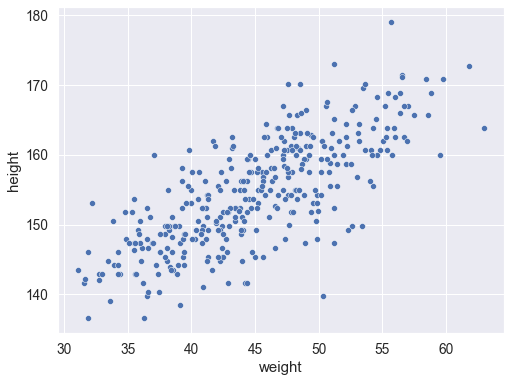

In [176]:
sns.scatterplot("weight", "height", data=d2)

### How do we capture this relationship with a Bayesian model?
We're going to make the parameter for our Gaussian distribution mu into a linear function of the preditor variable, as well as of other new parameters.  With only a single predictor weight, which we'll call $x$, we have:

* $h_i$ ~ Normal(mu_i, sigma) (Likelihood)
* mu_i = alpha + beta($x_i$ - sample mean($x$))  (Linear model)
* alpha ~ Normal(178, 20) (prior)
* beta ~ Normal(0,10) (prior)
* sigma ~ Uniform(0, 50) (prior)

#### Are the priors for alpha and beta any good?  We should simulate:

In [183]:
height = torch.tensor(d2.height, dtype=torch.float)
weight = torch.tensor(d2.weight, dtype=torch.float)

In [179]:
torch.manual_seed(100)
a = dist.Normal(178, 20).sample(torch.Size([100]))
b = dist.Normal(0, 10).sample(torch.Size([100]))


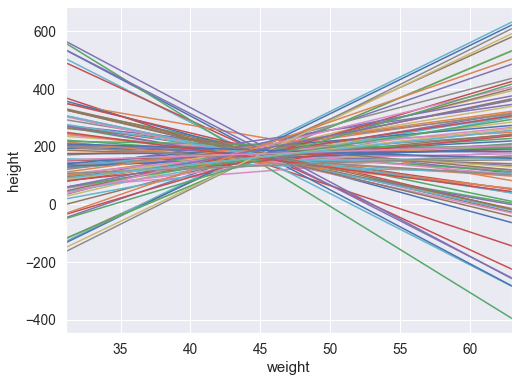

In [202]:
fig, ax = sns.mpl.pyplot.subplots()
ax.set(xlabel="weight", ylabel="height")
ax.set_xlim(xmin=min(weight), xmax=max(weight))
weight_range = torch.linspace(min(weight), max(weight), steps=100)
for al, be in zip(a, b):
    line = al + be*(weight_range - weight.mean()) 
    sns.lineplot(weight_range, line)

We know from our data plot this isn't realistic!  Let's try a better prior that restricts the weight/height relationship to positive values only, using a log-normal distribution for beta:
* beta ~ Log-Normal(0,1)

In [182]:
torch.manual_seed(100)
a = dist.Normal(178, 20).sample(torch.Size([100]))
b = dist.Normal(0, 10).sample(torch.Size([100]))

TypeError: 'zip' object is not subscriptable

In [185]:
max(weight)

tensor(62.9926)